In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import gc

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Organización de Datos/TP2/dataset_v2/train.parq')

Dropeo NaNs y columnas duplicadas.

Las columnas duplicadas no aportan ningún tipo de dato nuevo.

Las rows que tienen algún NaN representan menos del 1% del dataset, por lo que no afectarán el análisis considerando que no son todas de label 1 (si fueran todas de label1 sería un problema porque estaría trabajando sobre algo no representativo, pero no es el caso).

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.drop_duplicates(inplace=True)

#drop_duplicates sin anter dropear NaNs hace que no sea suficiente la memoria, me facilita las cosas para esta instancia de visus.

In [ ]:
df_aux = df[['attack_type','label']]
df_aux['attack_protocol'] = df_aux['attack_type'].map(lambda x: x.split(':')[0]).astype('category')
df_aux['attack_type'] = df_aux['attack_type'].map(lambda x: x.split(':')[1]).astype('category')

<ipython-input-8-c7cce600165f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['attack_protocol'] = df_aux['attack_type'].map(lambda x: x.split(':')[0]).astype('category')
<ipython-input-8-c7cce600165f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['attack_type'] = df_aux['attack_type'].map(lambda x: x.split(':')[1]).astype('category')


In [ ]:
attacks_by_type = pd.pivot_table(df_aux[df_aux.label == 1],values=['label'],index=['attack_type'],aggfunc='count',fill_value=0)

In [ ]:
attacks_by_type

,label
attack_type,
bruteforce,138701
crawl,3905
exploit,139971
scan,177330
spam,251403
unknown,5332


Text(0.5, 1.0, 'Distribución de ataques VPN/Proxy por tipo')

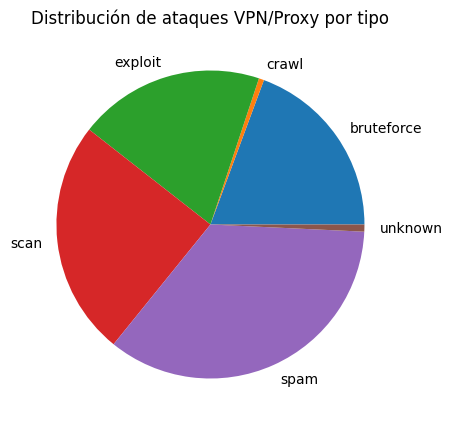

In [ ]:
fig, ax = plt.subplots()
plot = attacks_by_type.plot.pie(y='label',  figsize=(5, 5), legend=None, ax=ax, autopct='')
ax.axis('off')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xlabel('')

plt.title('Distribución de ataques VPN/Proxy por tipo')

Dividí la columna attack_type entre protocolo y tipo, y analicé la cantidad de ataques por cada tipo de ataque existente. Puede verse que hay tipos de ataques que tienen una mayor cantidad de labels 1.

La cantidad de labels 1 por sí sola quizá no sea útil, porque puede haber una cantidad enorme de mensajes de tipo spam comparado a los demas y, por ende, causará que haya una mayor cantidad con label 1, pero quizás solo sea un porcentaje muy bajo respecto al total de ataques de spam.

Esto puede ser útil combinándolo con el siguiente bar plot que voy a hacer, en donde considero la media de labels 1 por tipo de ataque.

El mismo análisis podía hacerse con los protocolos del ataque, y se obtienen resultados similares combinando los dos plots.

In [ ]:
attacks_by_type = pd.pivot_table(df_aux,values=['label'],index=['attack_type'],aggfunc='mean',fill_value=0).reset_index()

In [ ]:
attacks_by_type.rename(columns={"label": "% VPN/Proxy attacks"}, inplace=True)

Text(0.5, 0, 'Tipo de ataque')

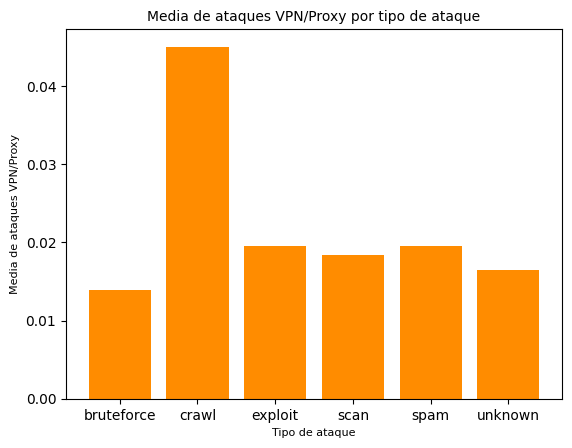

In [ ]:
plt.bar(attacks_by_type['attack_type'], attacks_by_type['% VPN/Proxy attacks'], width=0.8, color='darkorange')
plt.title('Media de ataques VPN/Proxy por tipo de ataque', fontsize=10)
plt.ylabel('Media de ataques VPN/Proxy',  fontsize=8)
plt.xlabel('Tipo de ataque',  fontsize=8)

Hice lo mismo que para el plot anterior, y puede verse que hay tipos de ataque que tienen una media de labels 1 mayor a los demás, como es el caso de crawl. También podemos ver, por ejemplo, que un ataque de tipo spam tiene mayor promedio de labels 1 que uno de bruteforce.

Combinando esto con el pie chart de cantidades, podemos ver que quizás sea interesante esta feature para un modelo, considerando que crawl tiene una media alta de ataques VPN/Proxy pero aparece poco, o que spam y bruteforce aparecen mucho pero spam tiene media mayor (la diferencia no es tan grande, y desconozco si en un modelo esto servirá o será contraproducente)

Lo mismo que hice con los tipos puedo hacerlo con los protocolos, y se ve que ocurre un cosa similar.

In [ ]:
attacks_by_type = ''
gc.collect()

40

In [ ]:
df_aux = df[['attacker_country','label']]

In [ ]:
attacks_by_country = pd.pivot_table(df_aux,values='label',index='attacker_country',aggfunc='mean',fill_value=0).nlargest(10, columns='label')
attacks_by_country.rename(columns={"label": "% VPN/Proxy attacks"}, inplace=True)
attacks_by_country.reset_index(inplace=True)

Text(0.5, 0, 'País atacante')

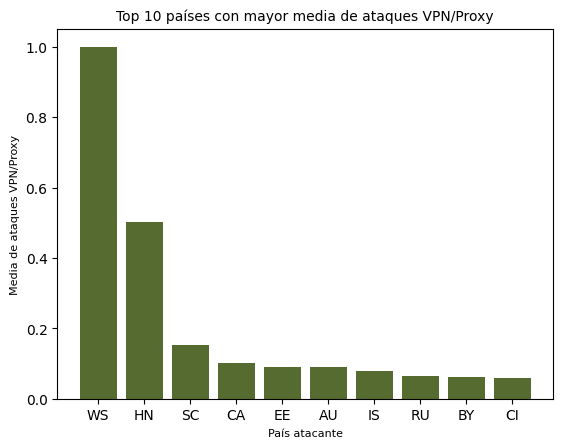

In [ ]:
plt.bar(attacks_by_country['attacker_country'], attacks_by_country['% VPN/Proxy attacks'], width=0.8, color='darkolivegreen')
plt.title('Top 10 países con mayor media de ataques VPN/Proxy', fontsize=10)
plt.ylabel('Media de ataques VPN/Proxy',  fontsize=8)
plt.xlabel('País atacante',  fontsize=8)

De la columna de país del atacante, consideré los 10 países con mayor media de ataques con ip asociada a un tipo VPN/Proxy y puede verse que hay países que solo tienen ataques de ese tipo, y que esto puede ser importante para predecir el target.

Teniendo eso en consideración, veré la correlación entre los países de los atacantes y los países de los observadores, para ver si puede ser útil esta segunda variable.

In [ ]:
top10_attacker_countries = attacks_by_country.attacker_country

In [ ]:
attacks_by_country = ''
gc.collect()

25

In [ ]:
top10freq_watcher_countries = df['watcher_country'].value_counts().reset_index().nlargest(10, 'watcher_country')['index']

In [ ]:
df_aux = df[['attacker_country', 'watcher_country', 'label']]

In [ ]:
df_aux = df_aux[df_aux['attacker_country'].isin(top10_attacker_countries)]
df_aux = df_aux[df_aux['watcher_country'].isin(top10freq_watcher_countries)]

In [ ]:
top10_attacker_countries

0    WS
1    HN
2    SC
3    CA
4    EE
5    AU
6    IS
7    RU
8    BY
9    CI
Name: attacker_country, dtype: category
Categories (214, object): ['AD', 'AE', 'AF', 'AG', ..., 'YE', 'ZA', 'ZM', 'ZW']

In [ ]:
top10_attacker_countries = ''
top10freq_watcher_countries = ''
gc.collect()

0

In [ ]:
countries = df_aux.pivot_table(index='watcher_country', columns='attacker_country', values='label', aggfunc='mean', fill_value=0)

Text(0.5, 1.0, 'Media de ataques VPN/Proxy entre países observadores con mayor frecuencia y atacantes con mayor media')

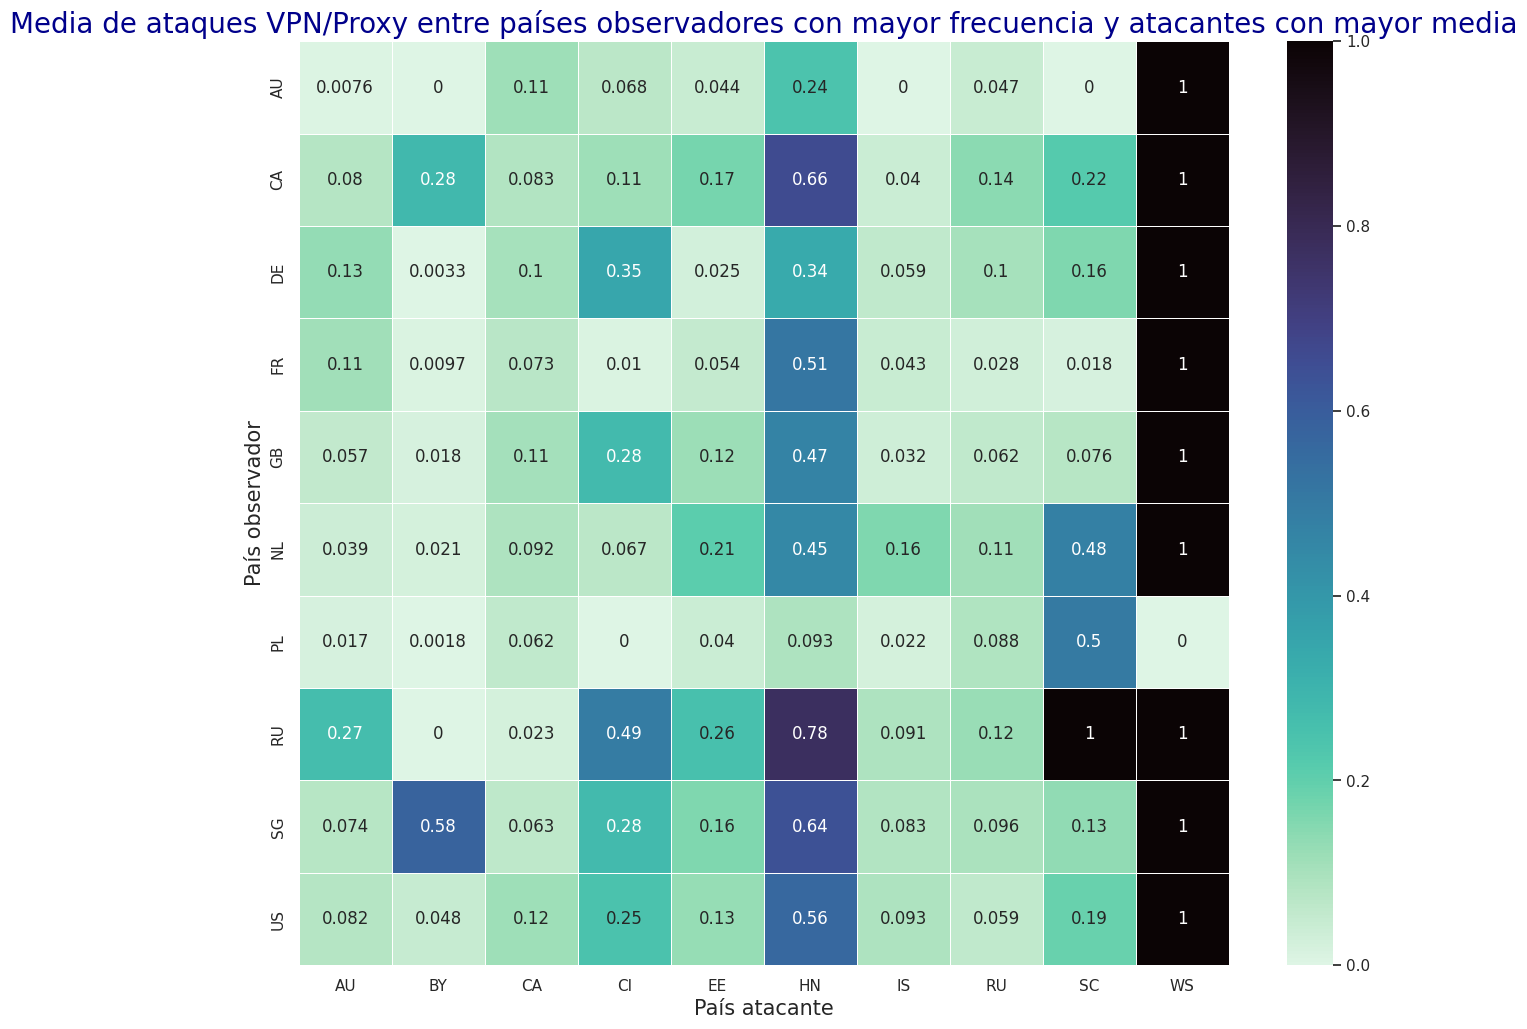

In [ ]:
sns.set (rc = {'figure.figsize':(15, 12)})
s=sns.heatmap(countries,cmap='mako_r',annot=True, linewidth=0.5, linecolor='white')
s.set_xlabel('País atacante', fontsize=15)
s.set_ylabel('País observador', fontsize=15)
plt.title('Media de ataques VPN/Proxy entre países observadores con mayor frecuencia y atacantes con mayor media', size=20, color='darkblue')

Tome los 10 países con mayor media de labels 1, y los 10 países de observador con mayor frecuencia.

Los países atacantes tienen una media alta con respecto a otros, pero según el país del watcher esta media baja considerablemente, así que puede decirse que hay una correlación entre las variables y que, si consideramos importante al país del atacante, también deberíamos considerar como importante al del observador.

In [ ]:
countries = ''
gc.collect()

5

In [ ]:
def obtener_rangos_horarios(hora):
    if 0 <= hora < 2:
        return '0-2'
    elif 2 <= hora < 4:
        return '2-4'
    elif 4 <= hora < 6:
        return '4-6'
    elif 6 <= hora < 8:
        return '6-8'
    elif 8 <= hora < 10:
        return '8-10'
    elif 10 <= hora < 12:
        return '10-12'
    elif 12 <= hora < 14:
        return '12-14'
    elif 14 <= hora < 16:
        return '14-16'
    elif 16 <= hora < 18:
        return '16-18'
    elif 18 <= hora < 20:
        return '18-20'
    elif 20 <= hora < 22:
        return '20-22'
    else:
        return '22-24'

In [ ]:
df_aux = df[['attack_time', 'label']]

In [ ]:
df_aux['hora'] = df_aux['attack_time'].dt.hour
df_aux['dia'] = df_aux['attack_time'].dt.day_name().astype('category')
df_aux['rango_horario'] = df_aux['hora'].map(lambda x: obtener_rangos_horarios(x)).astype('category')

<ipython-input-31-614466c0b68e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['hora'] = df_aux['attack_time'].dt.hour
<ipython-input-31-614466c0b68e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['dia'] = df_aux['attack_time'].dt.day_name().astype('category')
<ipython-input-31-614466c0b68e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [ ]:
df_aux = df_aux.drop(['hora'], axis=1)
df_aux = df_aux.drop(['attack_time'], axis=1)

In [ ]:
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#orden_rangos = ['0-4', '4-8', '8-12', '12-16', '16-20', '20-24']
orden_rangos = ['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16', '16-18', '18-20', '20-22', '22-24']

df_aux['dia'] = pd.Categorical(df_aux['dia'], categories=orden_dias, ordered=True)
df_aux['rango_horario'] = pd.Categorical(df_aux['rango_horario'], categories=orden_rangos, ordered=True)

df_aux = df_aux[df_aux['label'] == 1]

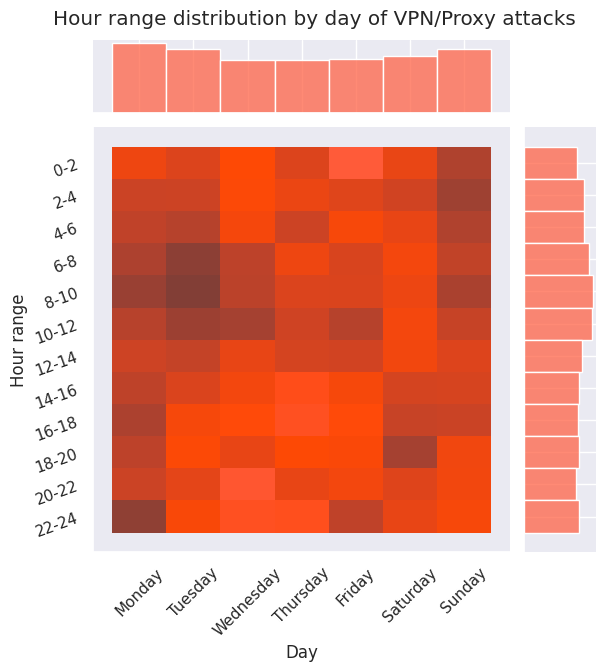

In [ ]:
g = sns.jointplot(x="dia", y="rango_horario", data=df_aux, kind="hist", color = 'tomato')
g.set_axis_labels("Day", "Hour range")
g.fig.suptitle("Hour range distribution by day of VPN/Proxy attacks", y=1.02)
plt.xticks(rotation=45)
plt.yticks(rotation=20)
g.ax_joint.yaxis.grid(False)
g.ax_joint.xaxis.grid(False)

plt.show()

Las fechas de los ataques son my similares, todas en el año 2023 y a lo largo de un par de meses, por lo que las descarté para este gráfico. Clasifiqué las horas en rangos horarios (de dos horas cada uno), por lo que cada ataque va a caer en uno de estos rangos.

Realicé el plot calculando la cantidad de ataque que ocurren en cierto rango horario y cierto día, y puede verse que suelen realizarse más ataques los días lunes que los otros, y que entre las 8 y las 12 horas hay una mayor cantidad de ataques.

No es tan clara la diferencia, y quizás no sean útiles estas features por si solas para entrenar un modelo.

In [ ]:
orden_dias = ''
orden_rangos= ''
gc.collect()

437

Sabemos que si una ip tiene label 1, siempre tendrá label 1, por lo que para los modelos no servirá para predecir sino para hacer el split de los datos en test/validation.

Ahora bien, los nombres/numeros (representan lo mismo) de los atacantes no siempre están asociados a la misma ip (un atacante puede tener distintas ips), y no siempre un atacante utiliza VPN o Proxy, así que quizás esta feature sea útil.

In [ ]:
df_aux = df[['watcher_as_name','attacker_as_name','label']]

In [ ]:
pd.pivot_table(df,values='label',index='attacker_as_name',aggfunc={'mean', 'count'},fill_value=0).nlargest(10, columns=['mean', 'count'])

,count,mean
attacker_as_name,,
F3 Netze e.V.,9921,1.0
THIN-NOLOGY,5841,1.0
QUINTEX,5281,1.0
Flokinet Ltd,5172,1.0
Vodafone Samoa Limited,3156,1.0
Zencurity ApS,2285,1.0
CALYX-AS,1607,1.0
Vayutel Technology Services Private Limited,1348,1.0
EMERALD-ONION,1083,1.0


Hay muchos atacantes que solo llevaron a cabo ataques usando VPN/Proxy.
Haciendo lo mismo con la columna watcher_as_name, de los watchers no hay ni siquiera uno que tenga asociados todos ataques de este tipo, y ninguno tiene una media muy alta que indique que el watcher influya considerablemente en que un label sea 1 o no.

Esto me dice que quizás sea conveniente utilizar la primera feature para predecir el target, pero de la segunda no me asegura mucho, aunque hay watchers con, considerablemente, mayor media que otros.

De modo similar a lo hecho con los países, tomaré watchers y attackers con mayor frecuencia en el dataset y haré un heat map para analizar la correlación entre estas variables.



In [ ]:
top20_watchers = df_aux['watcher_as_name'].value_counts().reset_index().nlargest(20, 'watcher_as_name')['index']
top20_attackers = df_aux['watcher_as_name'].value_counts().reset_index().nlargest(20, 'watcher_as_name')['index']

In [ ]:
df_aux = df_aux[df_aux['watcher_as_name'].isin(top20_watchers)]
df_aux = df_aux[df_aux['attacker_as_name'].isin(top20_attackers)]

In [ ]:
top20_attackers = ''
top20_watchers = ''
gc.collect()

0

In [ ]:
users = df_aux.pivot_table(index='watcher_as_name', columns='attacker_as_name', values='label', aggfunc='mean', fill_value=0)

Text(0.0, 1.0, 'Media de ataques VPN/Proxy entre observadores/atacantes con mayor frecuencia')

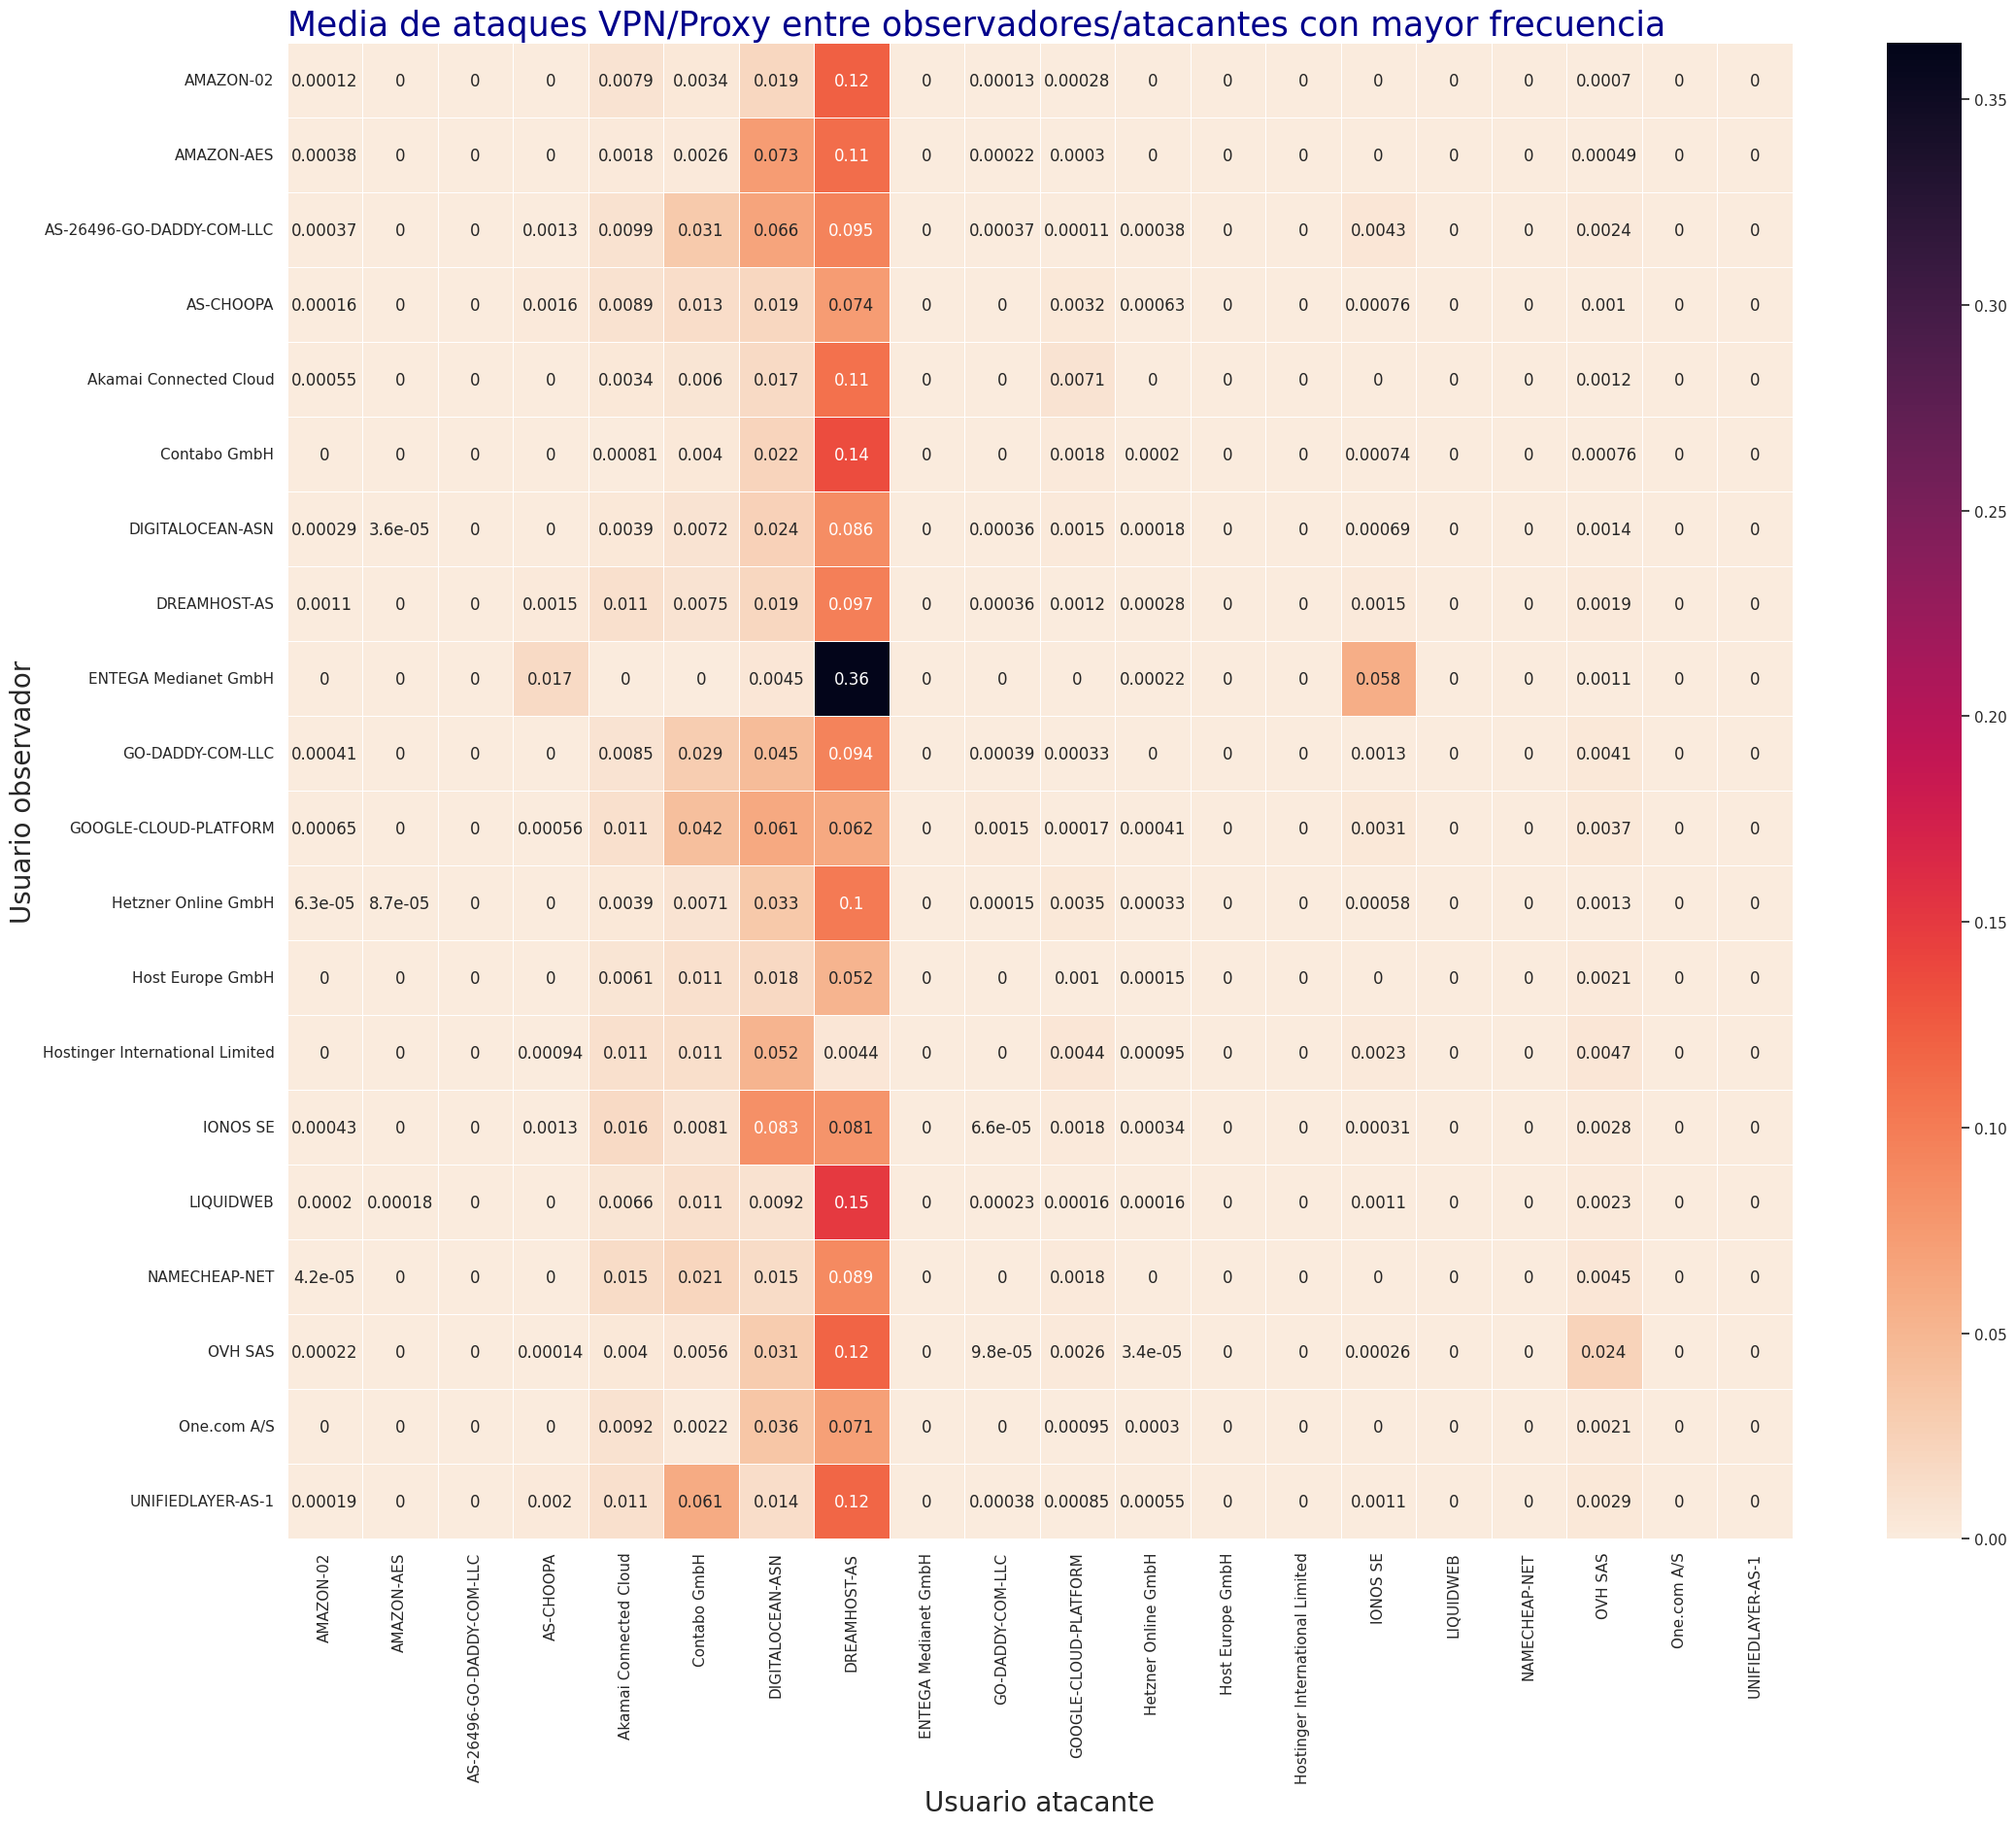

In [ ]:
sns.set (rc = {'figure.figsize':(25, 20)})
s=sns.heatmap(users,cmap='rocket_r',annot=True, linewidth=0.5, linecolor='white')
s.set_xlabel('Usuario atacante', fontsize=20)
s.set_ylabel('Usuario observador', fontsize=20)
plt.title('Media de ataques VPN/Proxy entre observadores/atacantes con mayor frecuencia', size=25, color='darkblue', loc='left')

Podemos observar que, si bien existen casos particulares, en general el heatmap queda determinado por los atacantes, notándose esto en las líneas verticales que se dibujan cuando un atacante tiene ip asociada con servicio VPN/Proxy.

Podría hacerse un heatmap parecido pero con los 20 watchers con mayor media de ataques asociados a VPN/Proxy, y quedaría algo similar (lo he probado), con columnas oscuras y en horizontal nada que parezca indicar que nombre del watcher influye en la media de ataques VPN/Proxy.

In [ ]:
users = ''
df_aux = ''
gc.collect()

5